<h1>Customer Behavior and Sales Insights Analysis</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('assignment_data.csv')


In [2]:
# Preview the dataset
print(df.head())

# Check basic info
print(df.info())

# Check missing values
print(df.isnull().sum())

# Check descriptive statistics
print(df.describe(include='all'))

   OrderID  CustomerID TransactionDate ProductID   ProductName  \
0  O543555        1273      07-04-2024      P102  Product-P102   
1  O871476        1053      04-05-2024      P258  Product-P258   
2  O627276        1078      16-01-2024      P865  Product-P865   
3  O171849        1221      15-05-2024      P261  Product-P261   
4  O707040        1037      18-01-2024      P791  Product-P791   

  ProductCategory  AmountSpent  DiscountApplied  FinalAmount PaymentMethod  \
0            Home       161.57            12.85       148.72           UPI   
1         Grocery        27.50             2.45        25.05   Credit Card   
2        Clothing       120.95             2.07       118.88          Cash   
3     Electronics       471.88           136.01       335.87   Credit Card   
4         Grocery       144.58            17.51       127.07          Cash   

    Location CustomerSignupDate  CustomerAge Gender IncomeGroup  
0  Bangalore         09-04-2023           52   Male         Low  
1 

In [4]:
# Changing the data type of TransactionDate , and CustomerSignupDate Column from object to Datetime

df['CustomerSignupDate'] = pd.to_datetime(df['CustomerSignupDate'], dayfirst=True)
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], dayfirst=True)

print(df.dtypes[['CustomerSignupDate', 'TransactionDate']])

CustomerSignupDate    datetime64[ns]
TransactionDate       datetime64[ns]
dtype: object


In [6]:
# Rename the AmountSpent column to Amount
df.rename(columns={'AmountSpent': 'Amount'}, inplace=True)

print(df.columns)

Index(['OrderID', 'CustomerID', 'TransactionDate', 'ProductID', 'ProductName',
       'ProductCategory', 'Amount', 'DiscountApplied', 'FinalAmount',
       'PaymentMethod', 'Location', 'CustomerSignupDate', 'CustomerAge',
       'Gender', 'IncomeGroup'],
      dtype='object')


<h2>Basic Exploratory Data Analysis<h2>

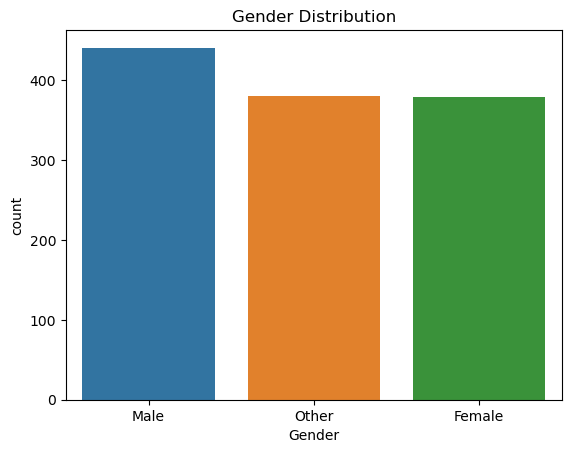

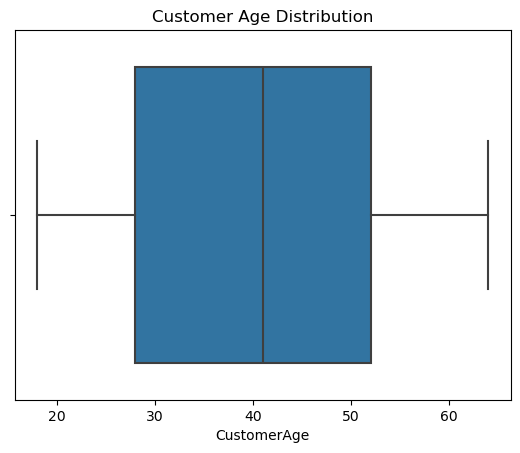

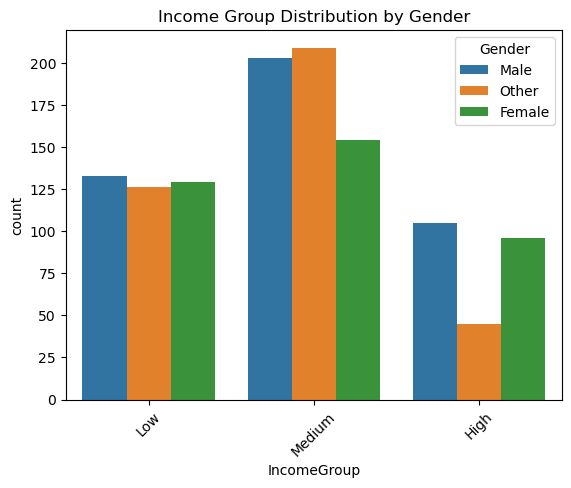

In [7]:
# Gender distribution
sns.countplot(x='Gender', data=df)
plt.title('Gender Distribution')
plt.show()

# Customer Age Distribution
sns.boxplot(x='CustomerAge', data=df)
plt.title('Customer Age Distribution')
plt.show()

# Income Group by Gender
sns.countplot(x='IncomeGroup', hue='Gender', data=df)
plt.title('Income Group Distribution by Gender')
plt.xticks(rotation=45)
plt.show()


<h2>Task 1 : RFM Analysis & Segmentation<h2>(RFM = Recency, Frequency, Monetary) 

In [8]:
# Setting the reference date for recency
reference_date = df['TransactionDate'].max()
print("Reference Date:", reference_date)


Reference Date: 2024-05-15 00:00:00


In [9]:
# Group by CustomerID
rfm = df.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (reference_date - x.max()).days,   # Recency
    'OrderID': 'nunique',                                           # Frequency
    'FinalAmount': 'sum'                                            # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Preview RFM table
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0        1001       77          2    219.09
1        1002        0          3    372.15
2        1003       23          2    414.22
3        1004        5          3     75.51
4        1005       22          7   1188.21


In [22]:
# Assign R, F, M scores (1 = worst, 4 = best)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4]).astype(int)

# Combine scores
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

print(rfm.head())



# Segmenting the Customers on the basis of R, F, M scores
def segment_customer(row):
    if (row['R_Score'] >= 3) and (row['F_Score'] >= 3) and (row['M_Score'] >= 3):
        return 'High Value'
    elif (row['R_Score'] >= 2) and (row['F_Score'] >= 2) and (row['M_Score'] >= 2):
        return 'Medium Value'
    elif (row['R_Score'] == 1) and (row['F_Score'] <= 2):
        return 'At Risk'
    elif (row['R_Score'] <= 2) and (row['F_Score'] <= 2):
        return 'Lost'
    else:
        return 'Low Value'


rfm['Segment'] = rfm.apply(segment_customer, axis=1)

print(rfm['Segment'].value_counts())



   CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0        1001       77          2    219.09        1        1        1   
1        1002        0          3    372.15        4        1        2   
2        1003       23          2    414.22        3        1        2   
3        1004        5          3     75.51        4        1        1   
4        1005       22          7   1188.21        3        4        4   

  RFM_Score     Segment  
0       111        Lost  
1       412   Low Value  
2       312   Low Value  
3       411   Low Value  
4       344  High Value  
Segment
Medium Value    92
High Value      71
Low Value       59
At Risk         52
Lost            19
Name: count, dtype: int64


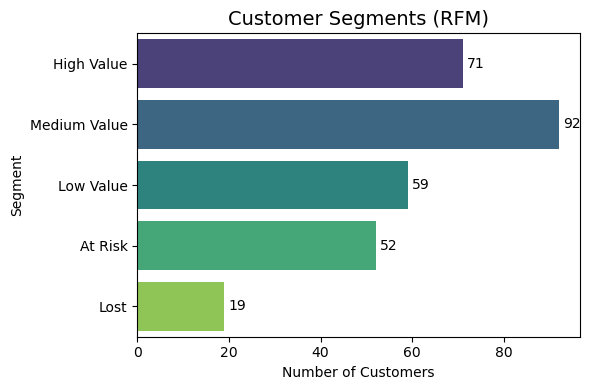

In [66]:
order = ['High Value', 'Medium Value', 'Low Value', 'At Risk', 'Lost']

plt.figure(figsize=(6, 4))
ax = sns.countplot(data=rfm, y='Segment', order=order, palette='viridis')
plt.title('Customer Segments (RFM)', fontsize=14)
plt.xlabel('Number of Customers')
plt.ylabel('Segment')

# Add values to bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

<h3>Suggestions for Each Segment :<h3>

1. High Value - Exclusive offers, upsell, referrals.

2. Medium Value - Targeted promos, product recommendations, loyalty push.

3. Low Value - Intro discounts, education, ease buying.

4. At Risk - Win-back offers, surveys, highlight new products.

5. Lost - Analyze churn, comeback offers, remove if inactive.

<h2>Task 2 : Cohort and Retention Analysis<h2>

In [26]:
# Extracting cohort month (signup month)
df['CohortMonth'] = df['CustomerSignupDate'].dt.to_period('M')

# Extracting transaction month
df['TransactionMonth'] = df['TransactionDate'].dt.to_period('M')

In [42]:
#Calculating the "Cohort Index" — number of months since signup

from operator import attrgetter

df['CohortIndex'] = (df['TransactionMonth'] - df['CohortMonth']).apply(attrgetter('n'))


In [43]:
cohort_counts = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().unstack(1)

# Retention as % of month 1
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0).round(3)


C:\Users\komal\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


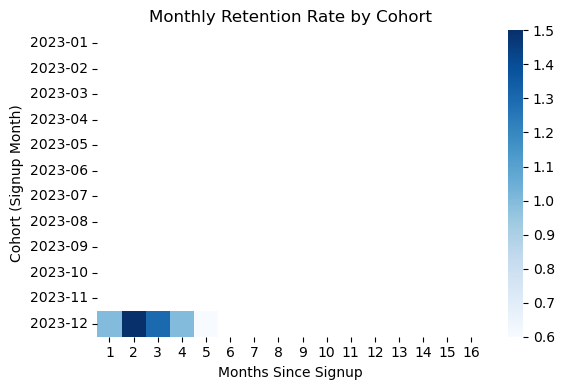

In [64]:

plt.figure(figsize=(6, 4))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues', cbar=True)
plt.title('Monthly Retention Rate by Cohort')
plt.xlabel('Months Since Signup')
plt.ylabel('Cohort (Signup Month)')
plt.tight_layout()
plt.show()


<h3>Interpretation :</h3>

Most customers joined in Dec 2023, had decent short-term engagement, but retention dropped steadily — signaling a need for better onboarding or ongoing engagement.

<h2>Task 3 : Product, Category & Location Insights<h2>

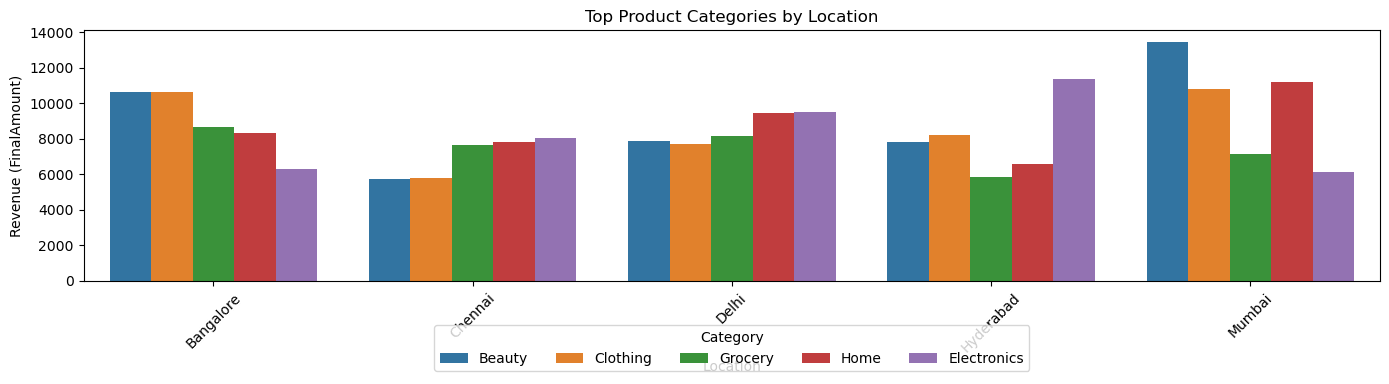

In [62]:
#Top Product Categories by Location

plt.figure(figsize=(14, 4))
ax = sns.barplot(data=top_categories, x='Location', y='FinalAmount', hue='ProductCategory')
plt.legend(title='Category', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(top_categories['ProductCategory'].unique()))
plt.title('Top Product Categories by Location')
plt.ylabel('Revenue (FinalAmount)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



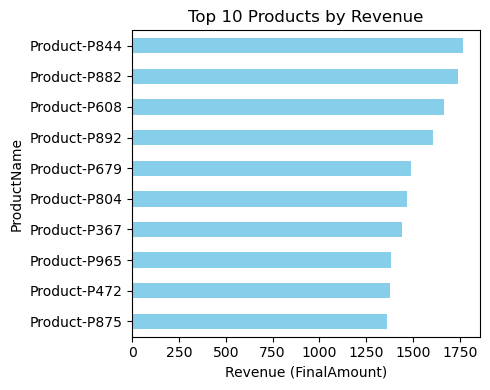

In [61]:
#Top Products by FinalAmount

top_products = df.groupby('ProductName')['FinalAmount'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', figsize=(5, 4), color='skyblue')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue (FinalAmount)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


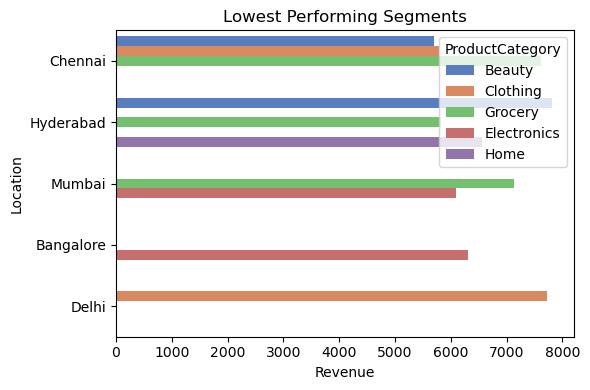

In [59]:
#Identify Low Performing Segments

low_perf = df.groupby(['Location', 'ProductCategory'])['FinalAmount'].sum().reset_index()
low_perf = low_perf.sort_values('FinalAmount').head(10)

plt.figure(figsize=(6, 4))
sns.barplot(data=low_perf, x='FinalAmount', y='Location', hue='ProductCategory', palette='muted')
plt.title('Lowest Performing Segments')
plt.xlabel('Revenue')
plt.tight_layout()
plt.show()


<h3>Marketing Spend Recommendations :</h3>

1) Bangalore: Prioritize Beauty and Clothing due to strong performance. Minimize spend on Electronics, which underperforms.

2) Chennai: Focus on Electronics and Home for highest ROI. Limit investment in Beauty, Clothing, and Grocery.

3) Delhi: Increase budget for Electronics and Home, the top revenue drivers. Cut back on Clothing marketing.

4) Hyderabad: Emphasize Electronics and Clothing, with moderate Beauty spend. Reduce Grocery and Home efforts.

5) Mumbai: Concentrate on Beauty and Home categories. Scale down marketing for Electronics and Grocery.

